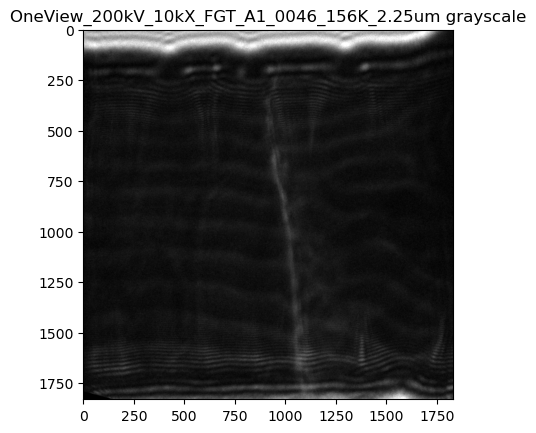

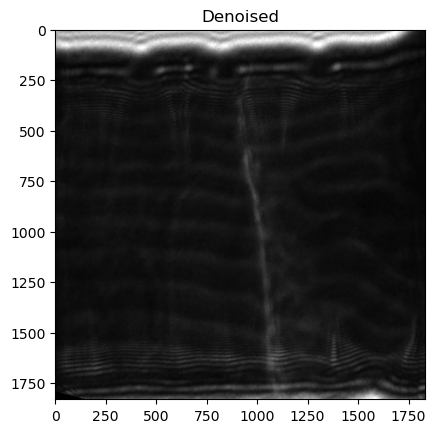

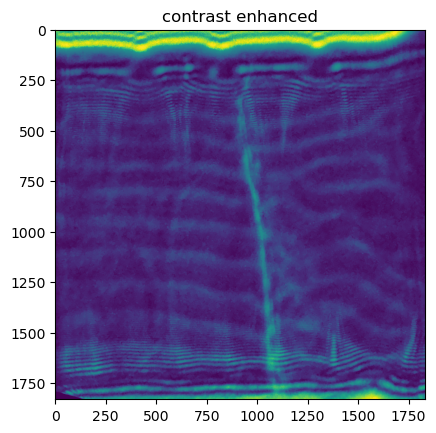

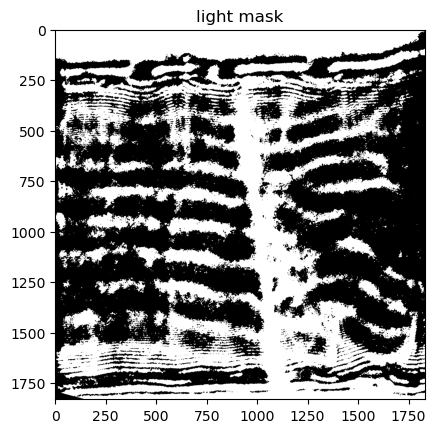

(1831, 1831)
light_pixels 1531925
total_pixels 3352561
dark_pixels 1820636
ratio 0.4569417230588795
OneView_200kV_10kX_FGT_A1_0046_156K_2.25um.png ratio of light pixels to total pixels:  0.4569417230588795


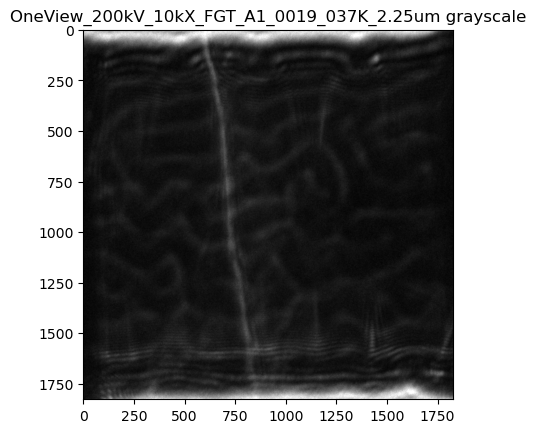

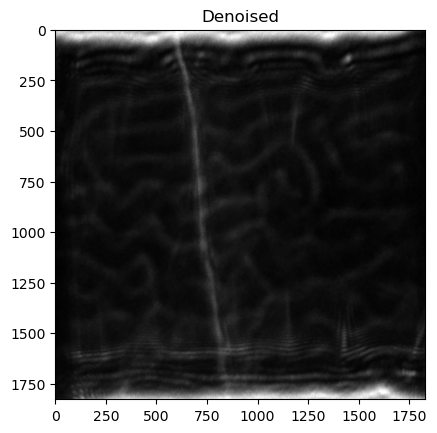

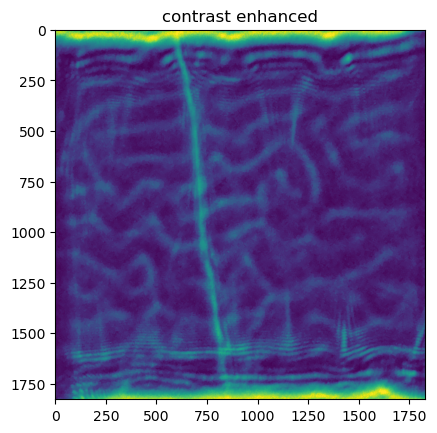

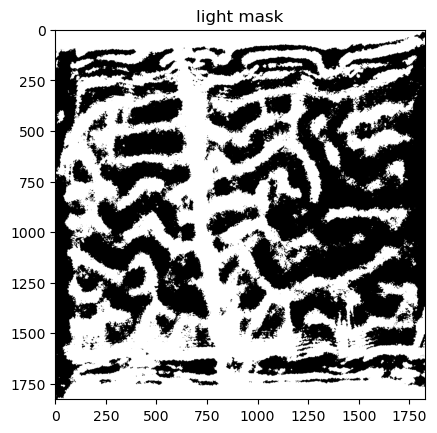

(1827, 1827)
light_pixels 1735302
total_pixels 3337929
dark_pixels 1602627
ratio 0.519873849923111
OneView_200kV_10kX_FGT_A1_0019_037K_2.25um.png ratio of light pixels to total pixels:  0.519873849923111


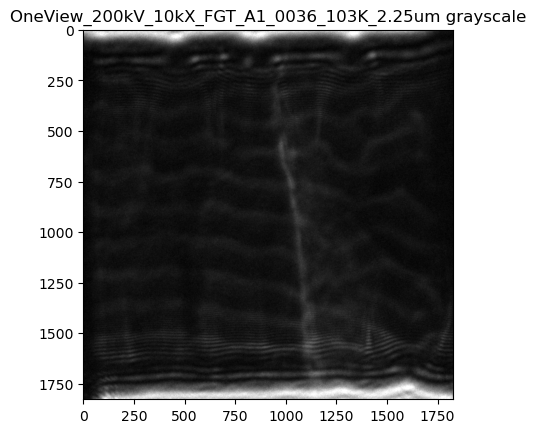

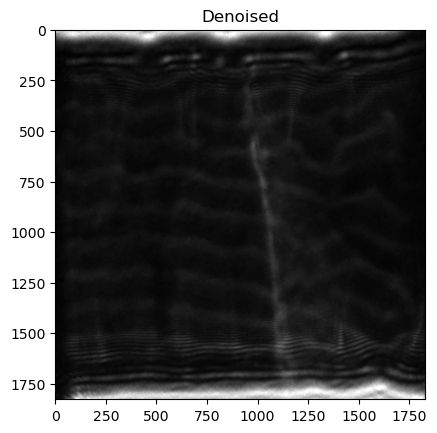

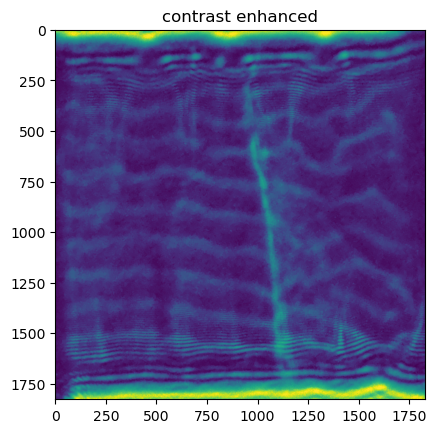

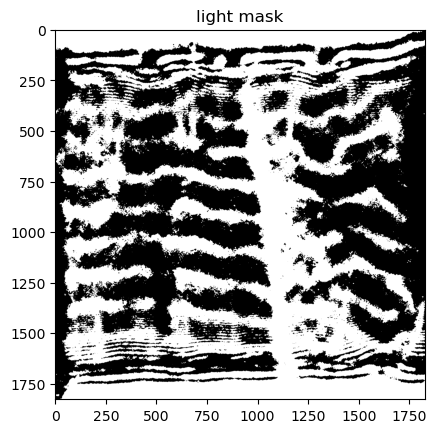

(1827, 1827)
light_pixels 1704370
total_pixels 3337929
dark_pixels 1633559
ratio 0.5106070260931254
OneView_200kV_10kX_FGT_A1_0036_103K_2.25um.png ratio of light pixels to total pixels:  0.5106070260931254


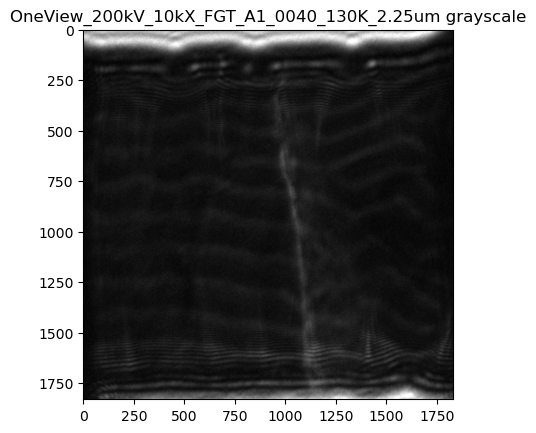

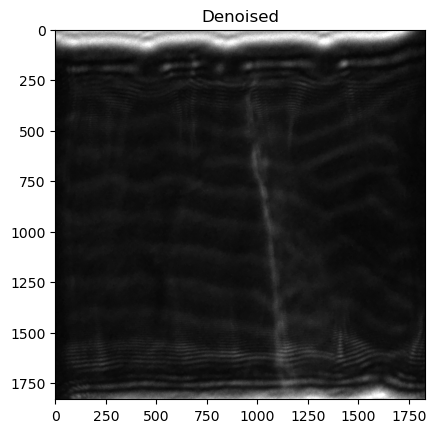

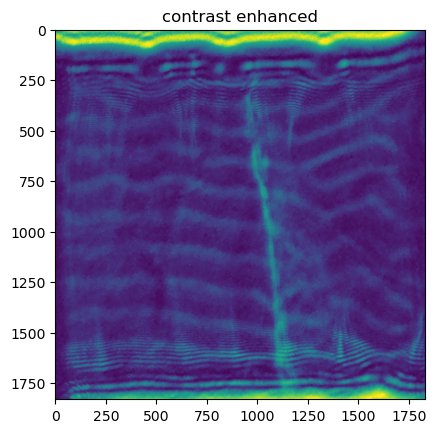

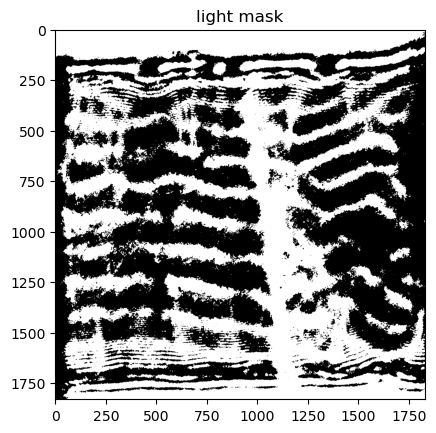

(1830, 1830)
light_pixels 1674219
total_pixels 3348900
dark_pixels 1674681
ratio 0.49993102212666846
OneView_200kV_10kX_FGT_A1_0040_130K_2.25um.png ratio of light pixels to total pixels:  0.49993102212666846


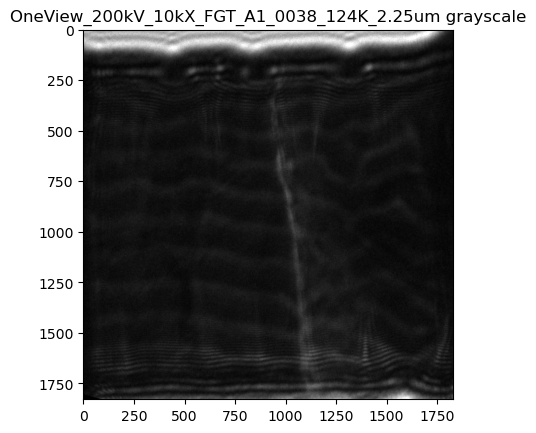

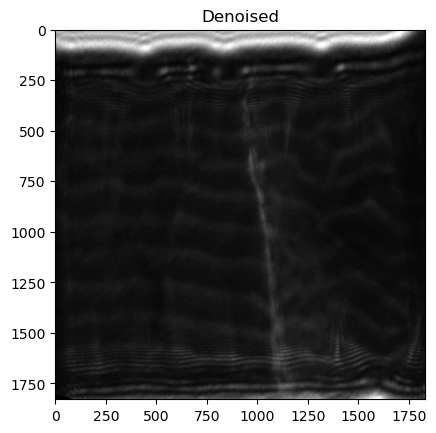

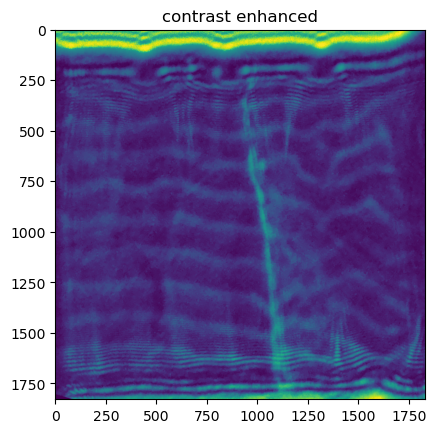

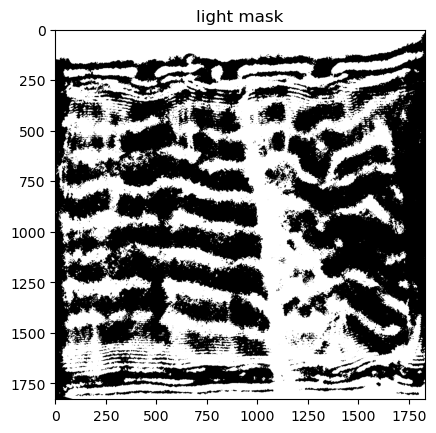

(1829, 1829)
light_pixels 1668849
total_pixels 3345241
dark_pixels 1676392
ratio 0.4988725774914274
OneView_200kV_10kX_FGT_A1_0038_124K_2.25um.png ratio of light pixels to total pixels:  0.4988725774914274


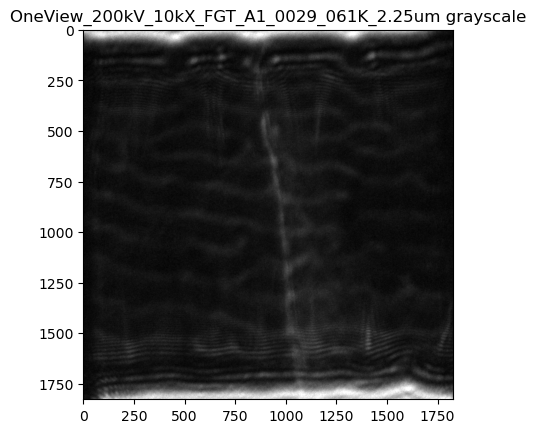

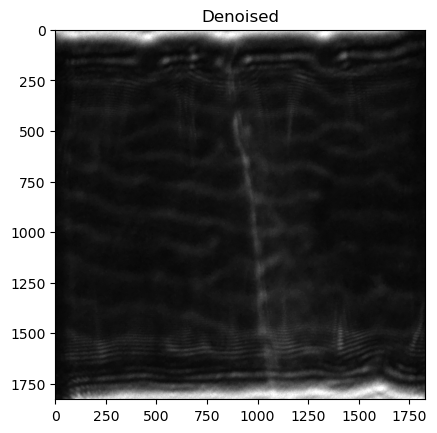

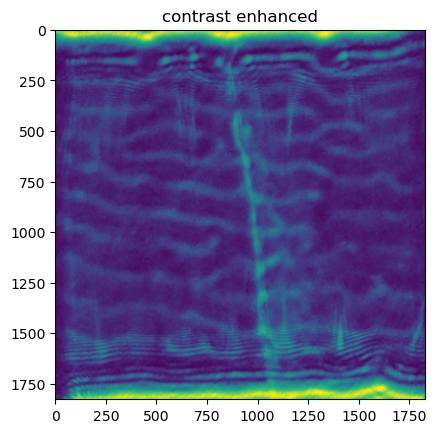

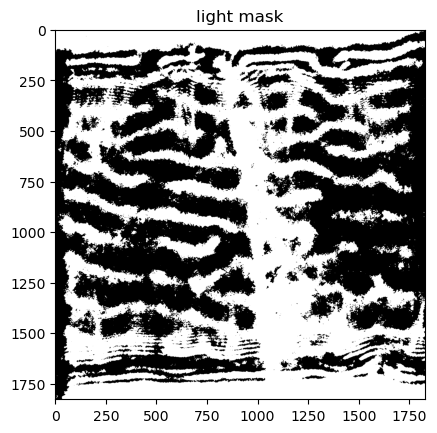

(1827, 1827)
light_pixels 1726011
total_pixels 3337929
dark_pixels 1611918
ratio 0.5170903874827775
OneView_200kV_10kX_FGT_A1_0029_061K_2.25um.png ratio of light pixels to total pixels:  0.5170903874827775


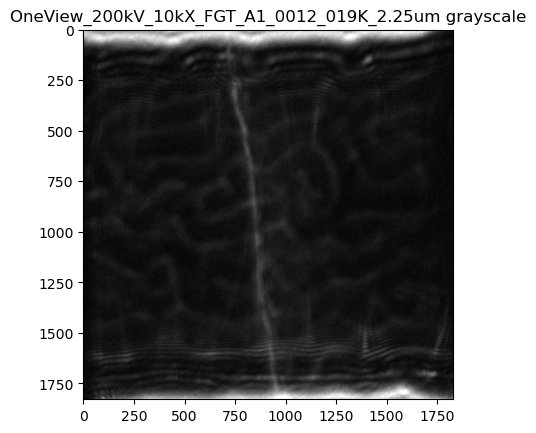

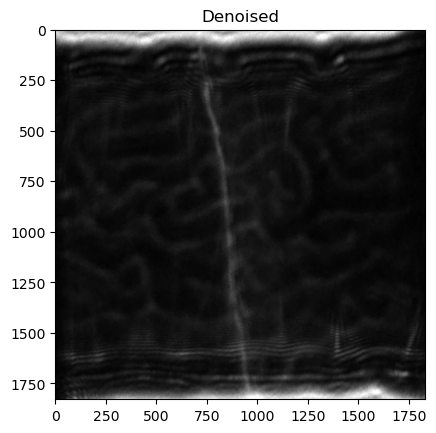

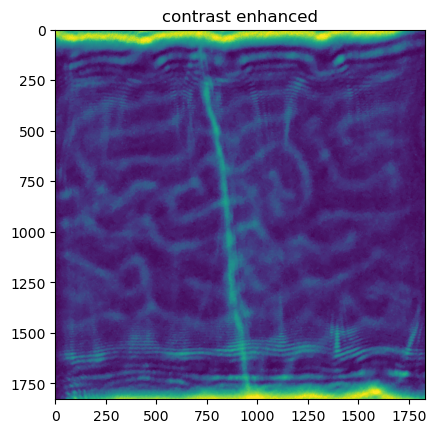

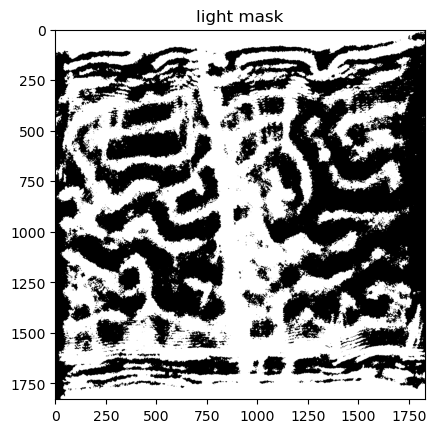

(1829, 1829)
light_pixels 1758642
total_pixels 3345241
dark_pixels 1586599
ratio 0.5257145897709612
OneView_200kV_10kX_FGT_A1_0012_019K_2.25um.png ratio of light pixels to total pixels:  0.5257145897709612


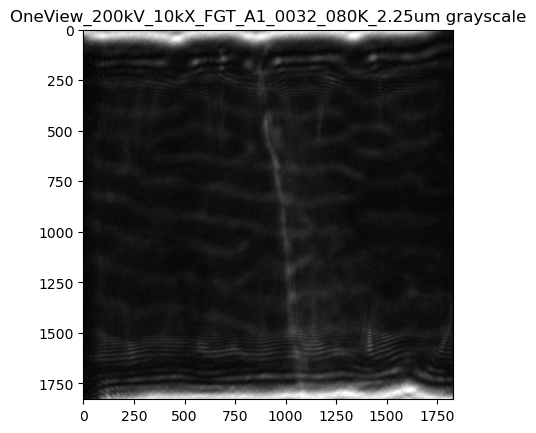

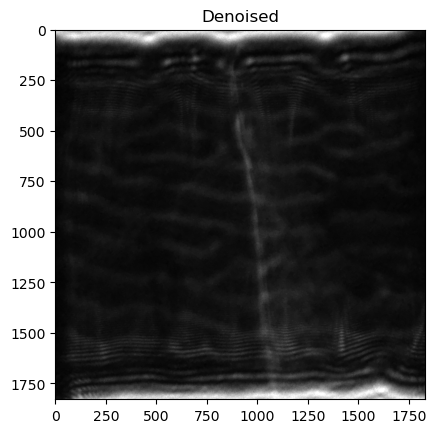

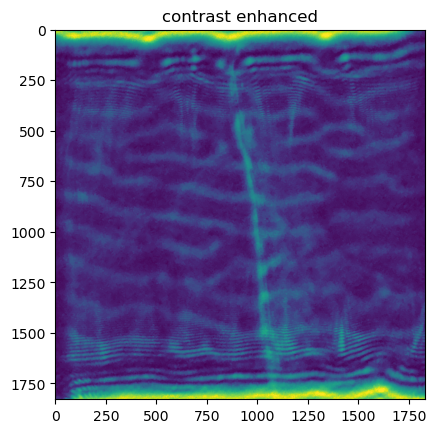

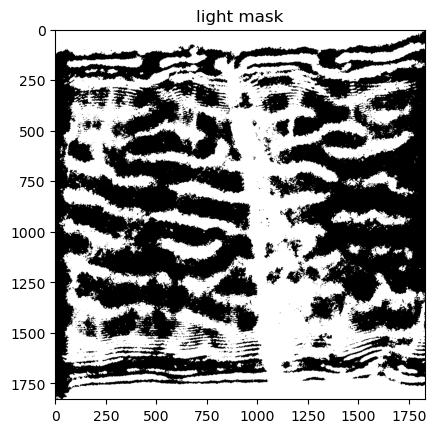

(1829, 1829)
light_pixels 1710707
total_pixels 3345241
dark_pixels 1634534
ratio 0.5113852783700785
OneView_200kV_10kX_FGT_A1_0032_080K_2.25um.png ratio of light pixels to total pixels:  0.5113852783700785


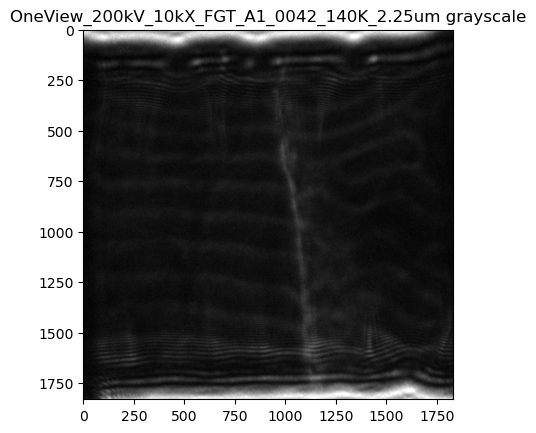

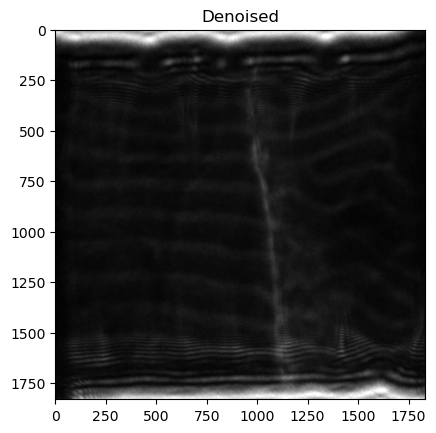

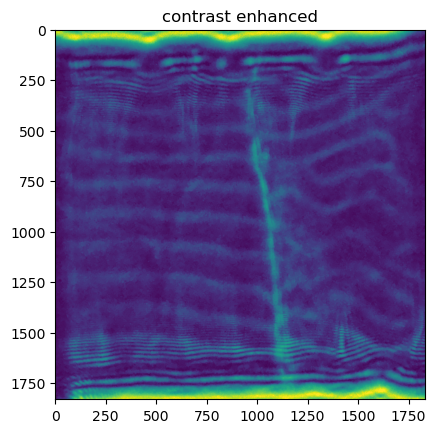

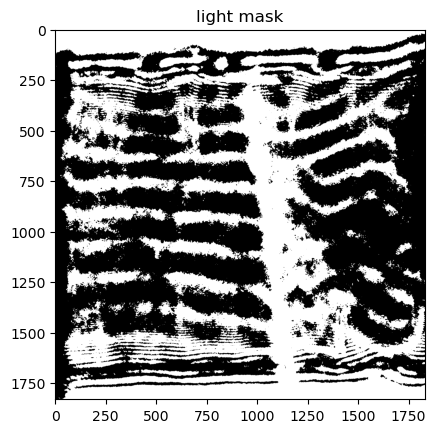

(1831, 1831)
light_pixels 1587615
total_pixels 3352561
dark_pixels 1764946
ratio 0.4735529047793612
OneView_200kV_10kX_FGT_A1_0042_140K_2.25um.png ratio of light pixels to total pixels:  0.4735529047793612


In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import re

# Load the image
current_path = os.getcwd()
folder_name= '6000OLF_MedRibbon_2mmDefocus_20DegTilt_Rotated15Deg'
DATA_PATH = os.path.join(current_path, 'images', folder_name) #path to where the data is saved


#image preprocessing: thresholds based on binary intensity level, optional edge detection
def preprocess_images(image, image_filename): 
    #denoise image to speed up processing time: #seems to make image quality worse! 
    image_denoised = cv2.fastNlMeansDenoising(image, None, 3, 7, 21)
    # image_denoised = image

    
    #plot: 
    plt.imshow(image_denoised, cmap='gray')
    plt.title('Denoised')
    plt.show()

    #enhance the contrast: 
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(image_denoised)
    plt.imshow(contrast_enhanced)
    plt.title('contrast enhanced')
    plt.show()
    
    # Threshold to detect light lines: higher threshold for bright features
    _, light_mask = cv2.threshold(contrast_enhanced, 35, 255, cv2.THRESH_BINARY) #first number is threshold, second number is what it converts pixels to 
    #18
    #plot: 
    plt.imshow(light_mask, cmap='gray')
    plt.title('light mask')
    plt.show()
    
    # #  apply edge detection to focus on line structures: don't think we need this, makes it harder to interpret results
    
    #result is either light_mask or light_edges, depending on what you want to do: 
    result= light_mask
    
    # Save the result
    output_path = os.path.join(DATA_PATH, 'processed')
    output_filename = os.path.join(output_path, image_filename.replace('.png','_thresholded.png'))
    cv2.imwrite(output_filename, result)
    return result

#light pixel ratio of each file (light pixels/ total pixels)
def image_lightdark_ratio(image, image_filename):
    light_pixels = cv2.countNonZero(image)
    print(image.shape)
    print('light_pixels', light_pixels)
    height, width = image.shape
    total_pixels = height*width
    print('total_pixels', total_pixels)
    dark_pixels = total_pixels-light_pixels
    print('dark_pixels', dark_pixels)
    ratio_light_to_total= light_pixels/total_pixels
    print('ratio', ratio_light_to_total)
    
    return ratio_light_to_total
    
#get temperature from filename (from ChatGPT): 
def extract_temperature(filename):
    # Use a regular expression to match the pattern 'xxxK' preceded by an underscore
    match = re.search(r'_(\d{3,})K', filename)
    
    # If a match is found, return the matched temperature
    if match:
        temp_str = match.group(1)  # Get the temperature as string (e.g., '017')
        return str(int(temp_str))  # Convert to int and back to string to remove leading zeroes
    else:
        raise ValueError("Temperature not found in filename")

#loop through everything in folder and do all images at once
file_stats=[] #to be written to the csv file
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".png"): #don't include txt files or folders
        #load the image:
        image_path = os.path.join(DATA_PATH, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # load image, convert to grayscale when loading
        #Display grayscale (unprocessed) image
        plt.imshow(image, cmap='gray')
        plt.title(filename.replace('.png', ' ')+'grayscale')
        plt.show() 
        #preprocess image:
        temperature= extract_temperature(filename)
        preprocessed_image = preprocess_images(image, filename)
        #get light to dark ratio: 
        image_ratio=image_lightdark_ratio(preprocessed_image, filename)
        file_stats.append([filename, round(image_ratio,3), temperature])
        print(filename, 'ratio of light pixels to total pixels: ', image_ratio)


#export as csv file with the light dark ratios: 
csv_filename= 'data_summary.csv'
csv_path=  output_path = os.path.join(DATA_PATH, 'processed',csv_filename)#csv filepath


with open(csv_path, 'w', newline='') as csvfile: 
    #write header
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['File name', 'Temperature (K)','Light pixel to total pixel ratio'])
    for name, ratio, temperature in file_stats: 
        csvwriter.writerow([name, temperature, ratio])
        
